This Notebook is used to make predictions: it returns the image with BBox of car plate license. It also extracts the text and saves it in a CSV file.

## 02_Predictions+ExtractText.ipynb

#### Import libraries

In [18]:
import cv2
import numpy as np
from skimage import io 
import matplotlib.pyplot as plt
import os
import easyocr 
import pandas as pd


#### Config variables

In [7]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

#### Load Model

In [8]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

#### Utils functions

In [19]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def extract_text(image, bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    reader = easyocr.Reader(['en'])
    result = reader.readtext(roi, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ',  detail=0)
    return result 


def drawings(image,boxes_np,confidences_np,index):
    #image = cv2.UMat(image)
    
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])
        if len(license_text) > 0:
            license_text = " ".join(license_text)
        else:
            license_text = ""


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)

        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image, license_text

# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img, text_ocr = drawings(img,boxes_np,confidences_np,index)
    return result_img, text_ocr

#### Predictions

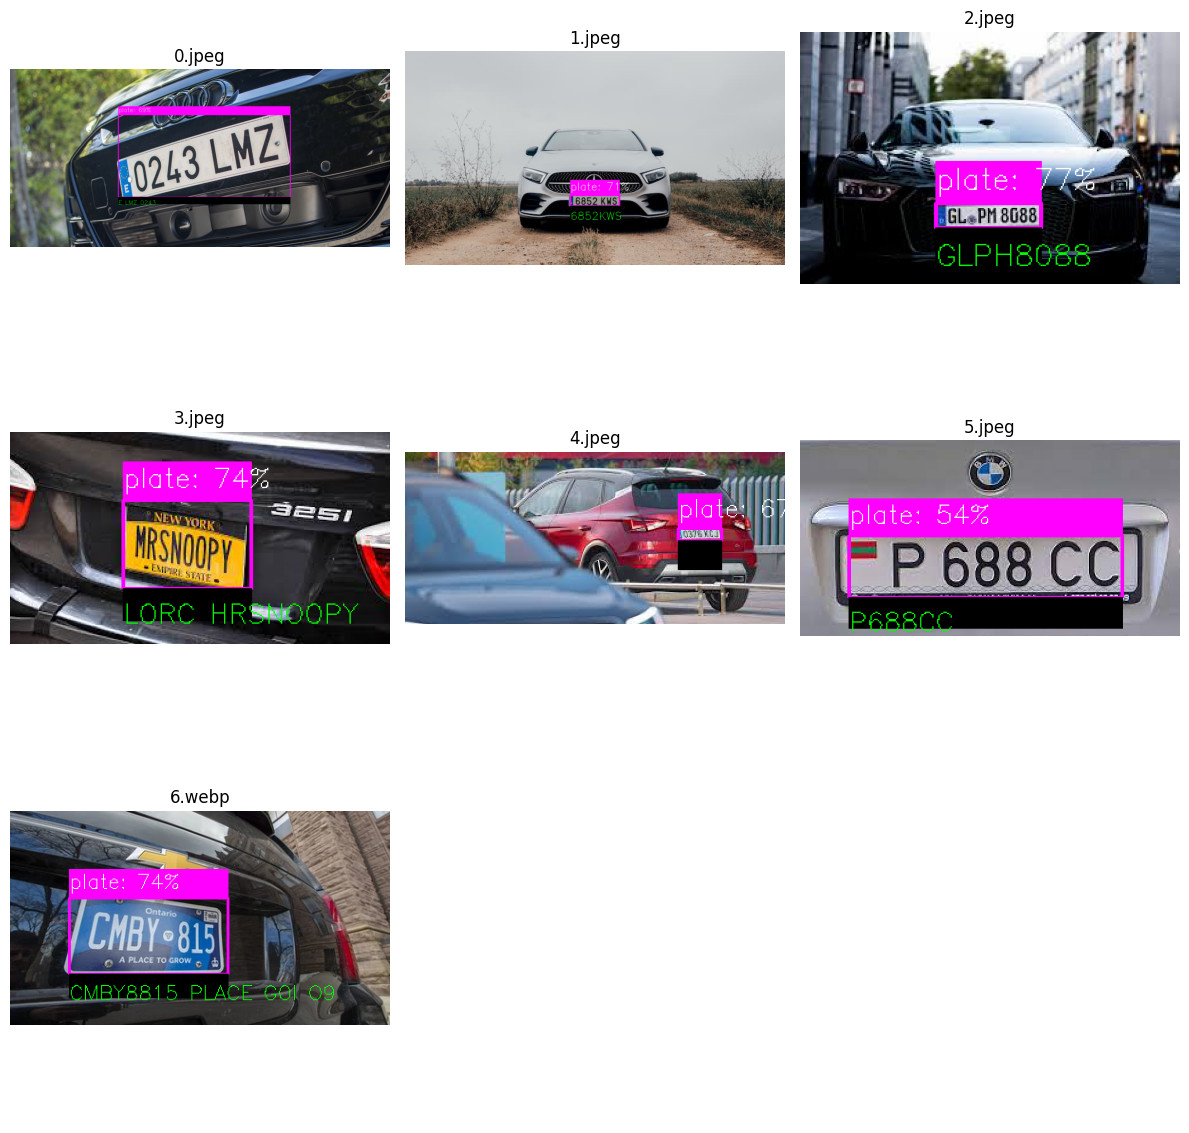

In [20]:
from matplotlib.image import imread
# path folder
ruta_carpeta = 'test'

# files names in folder
archivos = os.listdir(ruta_carpeta)
archivos = sorted(archivos)

# Delete .DS_Store (only Mac)
if '.DS_Store' in archivos:
    archivos.remove('.DS_Store')

#Create Dataframe
df = pd.DataFrame(columns=['Image','Text (OCR)'])
image_paths, texts_ocr = [], []


#Plot images
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.ravel()):
    # check if there are more images
    if i < len(archivos):
        # read image
        imagen = imread(os.path.join(ruta_carpeta, archivos[i]))
        # predictions
        imagen, text_ocr = yolo_predictions(imagen,net)
        image_paths.append(archivos[i])
        texts_ocr.append(text_ocr)

        # show image
        ax.imshow(imagen)
        ax.set_title(archivos[i])
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

#### Export results

In [21]:
df['Image'] = image_paths
df['Text (OCR)'] = texts_ocr
print(df)
#save dataframe to csv
# df.to_csv('results.csv', index=False)

    Image             Text (OCR)
0  0.jpeg             E LMZ 0243
1  1.jpeg                6852KWS
2  2.jpeg               GLPH8088
3  3.jpeg          LORC HRSNOOPY
4  4.jpeg                       
5  5.jpeg                 P688CC
6  6.webp  CMBY8815 PLACE GOI O9
